In [2]:
!pip install transformers scipy

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [2]:
df = pd.read_csv('reddit_stock_data_20250318_152214.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(2770, 14)
(500, 14)


In [3]:
df.head()
df['score']

0         2
1         0
2         4
3         9
4       368
       ... 
495      24
496      31
497     396
498    6179
499      31
Name: score, Length: 500, dtype: int64

In [4]:
example = df['clean_selftext'][4]
print(example)

started trading options October, one trade week. January 5k 15k invested. kept telling self gonna quit never did. thought “wow I’m really good this.” started losing trades, buying SPY calls etc whenever wrong doubled caused lose 3-4x gains. kept adding money never worked end Feb 10k… final 15k left made “educated” gamble SPY would react upcoming news news dropped 15->20k within 2 minutes. figured fuck let hold 25k market immediately corrected lost everything. ~30k peak 25k money worked two years save college for. Don’t know right tell family … anyone knows 10x bagger use break even I’d forever indebted


In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [30]:
def polarity_scores_roberta(example): 
    if not isinstance(example, str) or example.strip() == "":
        return None  # Handle cases where text is missing

    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {'roberta_neg': float(scores[0]), 
                'roberta_neu': float(scores[1]), 
                'roberta_pos': float(scores[2])}
    return scores_dict


In [31]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['clean_selftext']
        myid = row['id']

        # Handle missing or invalid text
        if not isinstance(text, str) or text.strip() == "":
            print(f"Skipping ID {myid} due to empty or invalid text")
            continue

        # Vader sentiment analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f'vader_{k}': v for k, v in vader_result.items()}  # Rename keys

        # RoBERTa sentiment analysis
        roverta_resul = polarity_scores_roberta(text)  # Ensure this returns a dictionary

        # Merge results
        both = {**vader_result_rename, **roverta_resul}
        res[myid] = both

    except RuntimeError:
        print(f"RuntimeError with ID {myid}")
        continue

    except ValueError as e:
        print(f"ValueError with ID {myid}: {e}")
        continue


  0%|          | 0/500 [00:00<?, ?it/s]

Skipping ID 1jed4vg due to empty or invalid text
Skipping ID 1jebn8s due to empty or invalid text
Skipping ID 1jeb3uq due to empty or invalid text
Skipping ID 1je9gyu due to empty or invalid text
Skipping ID 1je6ot8 due to empty or invalid text
Skipping ID 1je60dl due to empty or invalid text
Skipping ID 1je5hyi due to empty or invalid text
Skipping ID 1je5hny due to empty or invalid text
Skipping ID 1je58wh due to empty or invalid text
Skipping ID 1je2nwu due to empty or invalid text
Skipping ID 1jdr0k7 due to empty or invalid text
Skipping ID 1jdp3ug due to empty or invalid text
Skipping ID 1jdljm0 due to empty or invalid text
Skipping ID 1jdl7th due to empty or invalid text
Skipping ID 1jdkrct due to empty or invalid text
Skipping ID 1jdke0d due to empty or invalid text
Skipping ID 1jdh147 due to empty or invalid text
Skipping ID 1jdf2in due to empty or invalid text
Skipping ID 1jdc10v due to empty or invalid text
Skipping ID 1jd6l7y due to empty or invalid text
Skipping ID 1jd63zt 

In [32]:
RoBERTA = pd.DataFrame(res).T
RoBERTA = RoBERTA.reset_index().rename(columns={'index': 'id'})
RoBERTA = RoBERTA.merge(df, how = 'left')

In [33]:
RoBERTA.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,subreddit,title,...,author,created_utc,score,upvote_ratio,num_comments,url,selftext,clean_selftext,has_target_stock,mentioned_tickers
0,1jed83g,0.011,0.766,0.223,0.9976,0.036246,0.661350,0.302404,wallstreetbets,Can Newly Released NVIDIA Dynamo Open Source R...,...,Antonia45Heath,2025-03-18 15:16:09,2,1.00,3,https://www.reddit.com/r/wallstreetbets/commen...,First we need to know what the NVIDIA Dynamo O...,First need know NVIDIA Dynamo Open Source Reas...,1,NVDA
1,1jed5zw,0.273,0.727,0.000,-0.6440,0.430150,0.512040,0.057810,wallstreetbets,When do we start buying the dip?,...,GrassChew,2025-03-18 15:13:52,0,0.18,29,https://www.reddit.com/r/wallstreetbets/commen...,Tesla is at the same price it was at in late 2...,Tesla price late 2020 world's economy crash bo...,0,NaN
2,1jeb7d8,0.127,0.795,0.079,-0.6605,0.571882,0.361076,0.067042,wallstreetbets,College student (sophomore) looses everything ...,...,ViraliaTube,2025-03-18 13:54:52,368,0.87,295,https://www.reddit.com/gallery/1jeb7d8,"I started trading options in October, one trad...","started trading options October, one trade wee...",0,NaN
3,1je9lr3,0.192,0.536,0.273,0.1697,0.037042,0.483151,0.479807,wallstreetbets,NVDA GTC YOLO,...,WingWorried6176,2025-03-18 12:50:27,25,0.86,26,https://www.reddit.com/gallery/1je9lr3,MAXIMUM FEAR surrounding the GTC. Hoping Jense...,MAXIMUM FEAR surrounding GTC. Hoping Jensen bl...,1,NVDA
4,1je97nl,0.000,1.000,0.000,0.0000,0.100637,0.863767,0.035596,wallstreetbets,RDDT all in: Mansion or Wendy’s dumpster,...,zuckzuckonit,2025-03-18 12:34:14,48,0.83,61,https://i.redd.it/h7soq1zy6hpe1.jpeg,Is Wendy’s still taking job applications?,Wendy’s still taking job applications?,0,NaN


C:\Users\bwatts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\bwatts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\bwatts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\bwatts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:1513: UserWarni

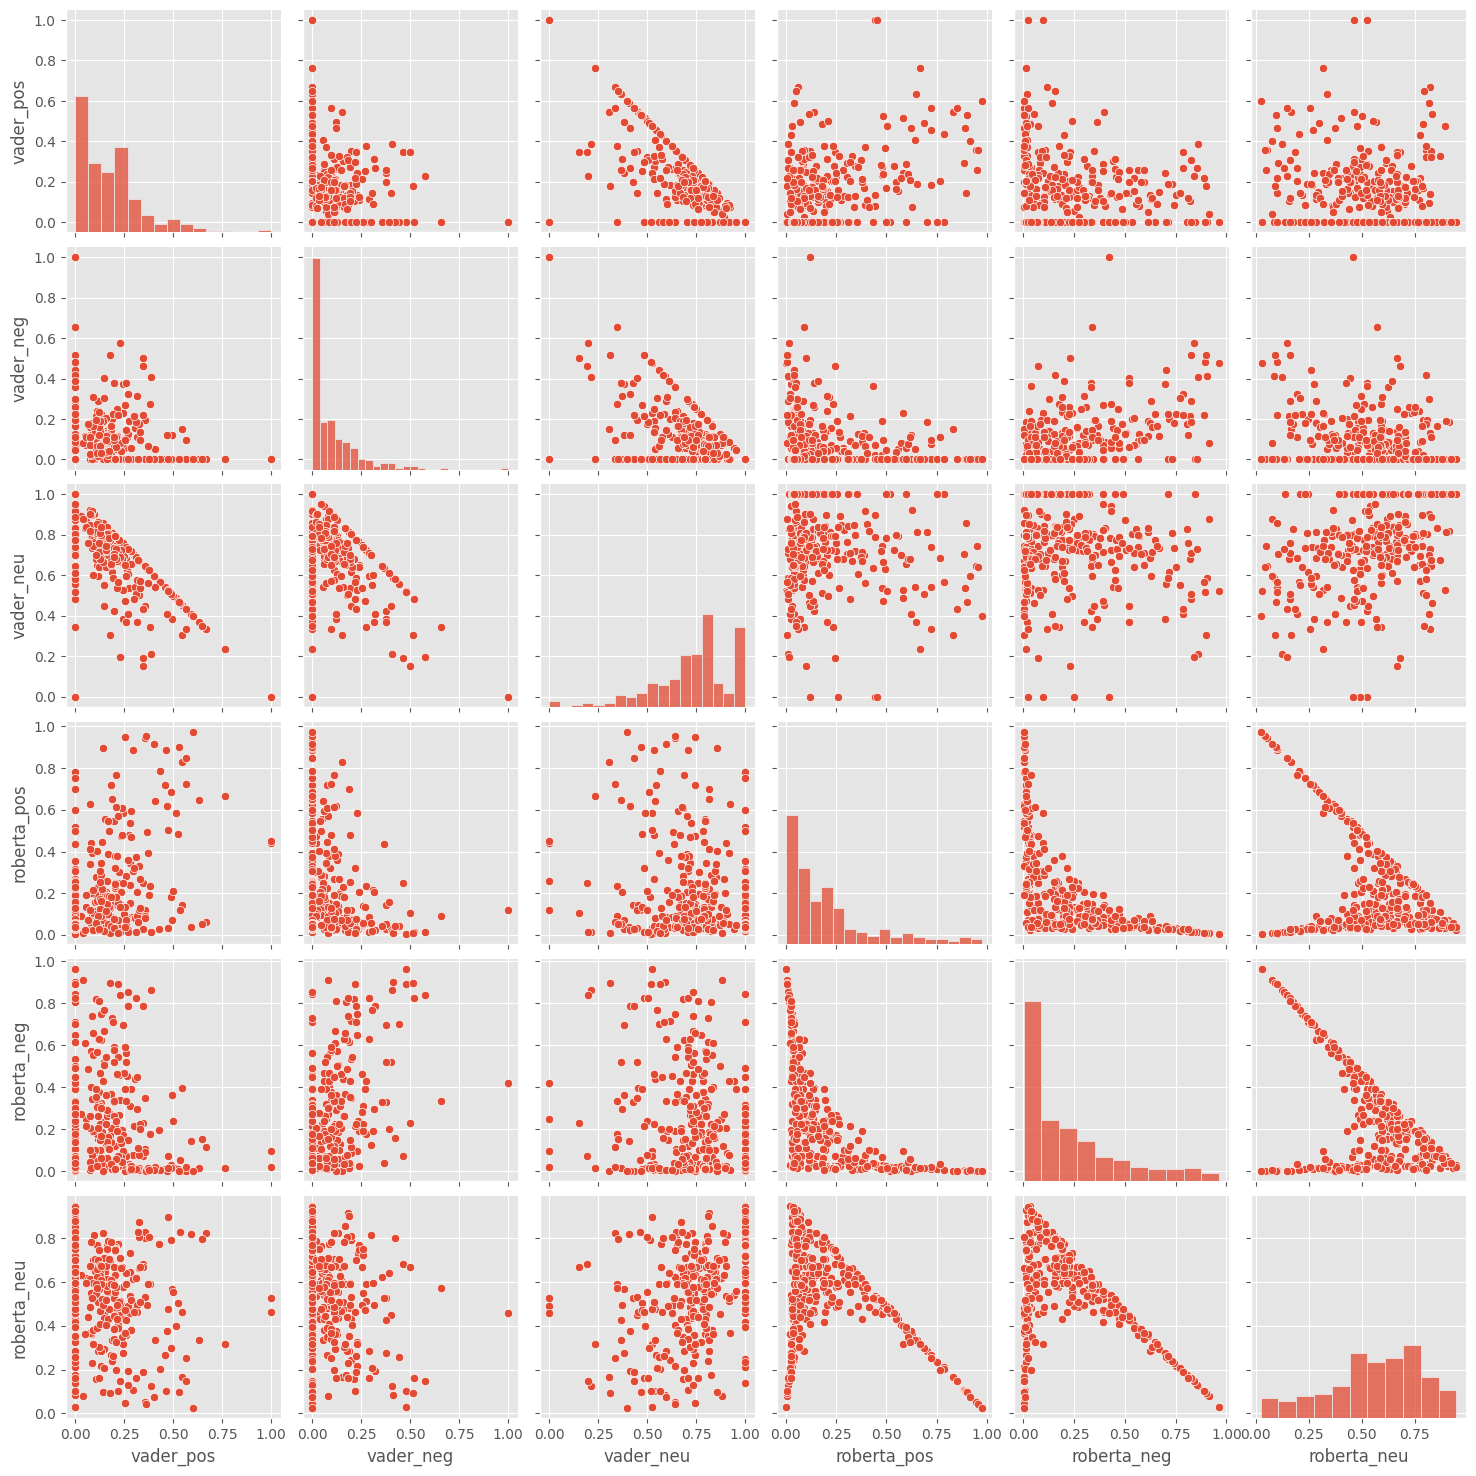

In [44]:
sns.pairplot(data = RoBERTA, vars=['vader_pos', 'vader_neg', 'vader_neu', 'roberta_pos', 'roberta_neg', 'roberta_neu'], palette='tab10')
plt.show()